In [ ]:
#References
#https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

In [2]:
!pip3 install transformers
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import AutoModel, BertTokenizerFast
import re
import matplotlib.pyplot as plt
device = torch.device("cuda")

In [3]:
#Load given Wikipedia dataset into a dataframe
df = pd.read_csv("train_hate_speech_analysis.csv")
df.drop(['id'],axis=1,inplace=True)
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
#Identify possible bias
print(df.iloc[:,1:].sum())

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [5]:
#Set labels for binary classification (0 NHOS / 1 HOS)
x=df.iloc[:,1:].sum()

rowsums=df.iloc[:,1:].sum(axis=1)

df['clean'] = np.where(df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['identity_hate'] == 0, 0, 1)

df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


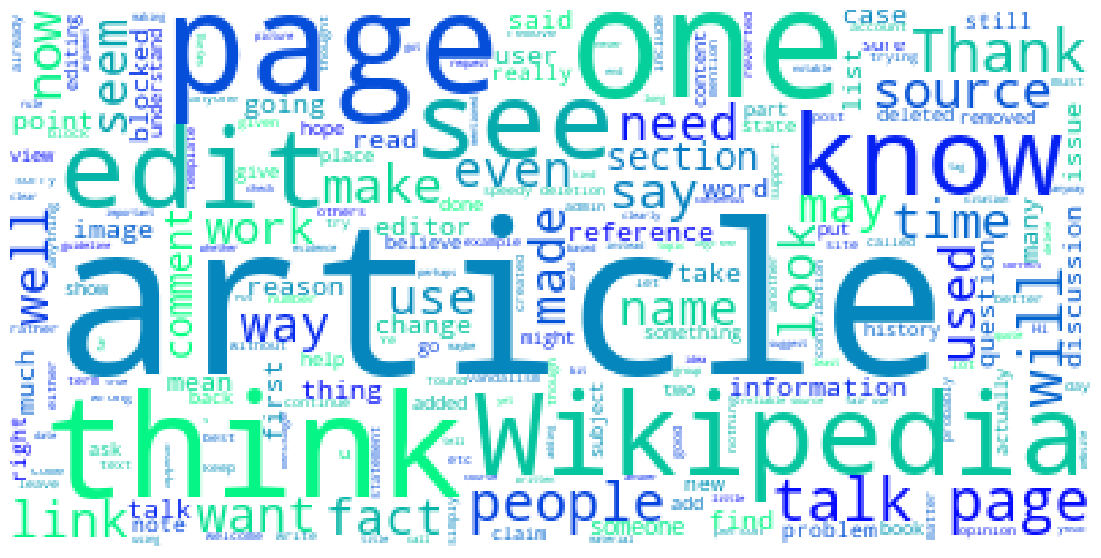

In [6]:
#Frequent words appearing in NHOS tuples
subset=df[df.clean==0]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=2000,stopwords=set(STOPWORDS))
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'winter' , random_state=17), alpha=0.98)
plt.show()

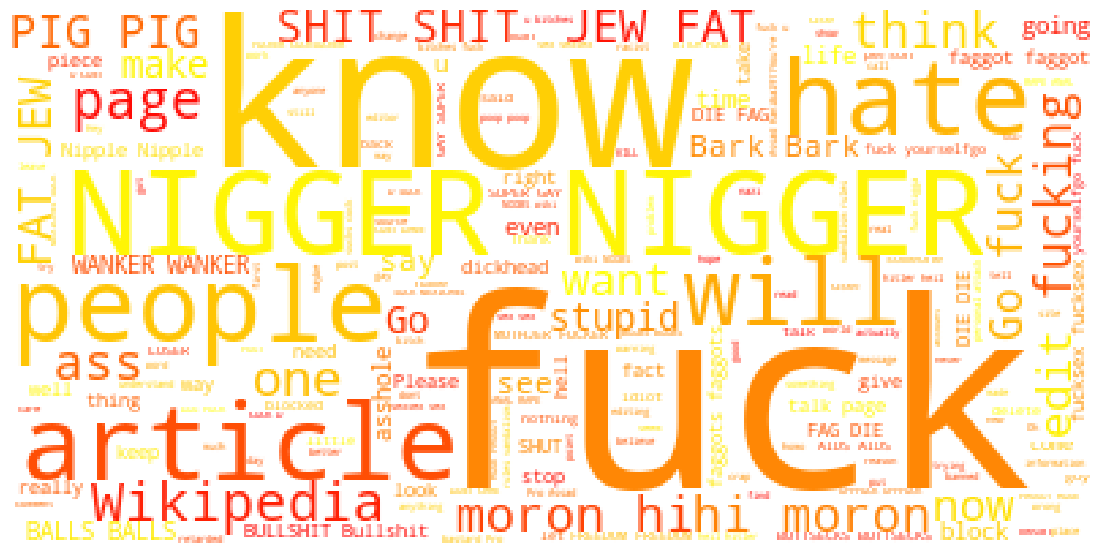

In [7]:
#Frequent words appearing in HOS tuples
subset=df[df.clean==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=2000,stopwords=set(STOPWORDS))
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'autumn' , random_state=17), alpha=0.98)
plt.show()

In [8]:
#List of abbriviations appearing in the dataset
ABR = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [9]:
#Preprocessing of dataset
def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', text) # clean url
    text = re.sub(r'#(\w+)', '', text)   # clean hashes
    text = re.sub(r'@(\w+)', '', text)   # clean @
    text = re.sub(r'<[^>]+>', '', text)  # clean tags
    text = re.sub(r'\d+', '', text)      # clean digits
    text = re.sub(r'[,!@\'\"?\.$%_&#*+-:;]', '', text)   # clean punctuation
    text = ' '.join(ABR[word] if word in ABR else word for word in text.split())
    
    return text

df['comment_text'] = df['comment_text'].apply(clean_text)
df.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0
3,more i cant make any real suggestions on impro...,0,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0
5,congratulations from me as well use the tools ...,0,0,0,0,0,0,0
6,cocksucker before you piss around on my work,1,1,1,0,1,0,1
7,your vandalism to the matt shirvington article...,0,0,0,0,0,0,0
8,sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


In [10]:
train_x = df.iloc[:,0]
train_y = df.iloc[:,7]

# we will use temp_text and temp_labels to create validation and test set
train_text, temp_text, train_labels, temp_labels = train_test_split(train_x,train_y, test_size=0.3, random_state=2018)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

In [11]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-large-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [13]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


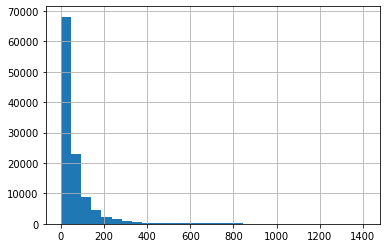

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [15]:
max_seq_len = 50

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
)

In [16]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 250

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [19]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(1024,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [21]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [22]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.55500954 5.04466625]


In [23]:
# convert class weights to tensor
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 5

In [24]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()       

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [25]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [26]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    447.
  Batch   100  of    447.
  Batch   150  of    447.
  Batch   200  of    447.
  Batch   250  of    447.
  Batch   300  of    447.
  Batch   350  of    447.
  Batch   400  of    447.

Evaluating...
  Batch    50  of     96.

Training Loss: 0.600
Validation Loss: 0.438

 Epoch 2 / 5
  Batch    50  of    447.
  Batch   100  of    447.
  Batch   150  of    447.
  Batch   200  of    447.
  Batch   250  of    447.
  Batch   300  of    447.
  Batch   350  of    447.
  Batch   400  of    447.

Evaluating...
  Batch    50  of     96.

Training Loss: 0.489
Validation Loss: 0.452

 Epoch 3 / 5
  Batch    50  of    447.
  Batch   100  of    447.
  Batch   150  of    447.
  Batch   200  of    447.
  Batch   250  of    447.
  Batch   300  of    447.
  Batch   350  of    447.
  Batch   400  of    447.

Evaluating...
  Batch    50  of     96.

Training Loss: 0.464
Validation Loss: 0.416

 Epoch 4 / 5
  Batch    50  of    447.
  Batch   100  of    447.
  Batch   

In [27]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [28]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq[1:1000].to(device), test_mask[1:1000].to(device))
  preds = preds.detach().cpu().numpy()

In [29]:
print(preds)

[[-0.0247976  -3.7093792 ]
 [-0.1613381  -1.9038374 ]
 [-0.06208481 -2.810136  ]
 ...
 [-1.1156964  -0.39703128]
 [-0.09198698 -2.4317486 ]
 [-0.20554209 -1.6831157 ]]


In [30]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y[1:1000], preds))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       905
           1       0.39      0.80      0.52        94

    accuracy                           0.86       999
   macro avg       0.68      0.83      0.72       999
weighted avg       0.92      0.86      0.88       999



In [31]:
# confusion matrix
pd.crosstab(test_y[1:1000], preds)

col_0,0,1
row_0,,
0,788,117
1,19,75
